# Load libraries

In [95]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce 

# Load data

Load selected features

In [96]:
# Load pickle file with the categorical features selected
import pickle
with open("C://Users/luisgasco/Documents/bosh_kaggle_comp/data/final_selected_features.pkl", 'rb') as f:
    df_importance_150 = pickle.load(f)
    
list_features = list(df_importance_150.feature_name)

In [97]:
dat_cols = list(pd.read_csv("C://Users/luisgasco/Documents/bosh_kaggle_comp/data/train_date.csv", nrows=0, dtype=np.float32).columns)
num_cols = list(pd.read_csv("C://Users/luisgasco/Documents/bosh_kaggle_comp/data/train_numeric.csv", nrows=0, dtype=np.float32).columns)
cat_cols = list(pd.read_csv("C://Users/luisgasco/Documents/bosh_kaggle_comp/data/train_categorical.csv", nrows=0).columns)

# Python program to find the common elements  
# in two lists 
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
  
    if (a_set & b_set): 
        lista = list(a_set & b_set) 
    else: 
        print("No common elements")  
    return lista
        
sel_cat = common_member(list_features, cat_cols)
sel_num = common_member(list_features, num_cols)
sel_dat = common_member(list_features, dat_cols)


In [205]:
sel_cat

['L3_S32_F3854']

In [175]:
date_chunks = pd.read_csv("C://Users/luisgasco/Documents/bosh_kaggle_comp/data/train_date.csv", usecols = sel_dat, chunksize=100000, dtype=np.float32)
num_chunks = pd.read_csv("C://Users/luisgasco/Documents/bosh_kaggle_comp/data/train_numeric.csv", chunksize=100000, dtype=np.float32, usecols = list(["Response"]) +sel_num)
cat_chunks = pd.read_csv("C://Users/luisgasco/Documents/bosh_kaggle_comp/data/train_categorical.csv", usecols = sel_cat, chunksize=100000)
X = pd.concat([pd.concat([dchunk, nchunk, cchunk], axis=1).sample(frac=0.4)
               for dchunk, nchunk, cchunk in zip(date_chunks, num_chunks, cat_chunks)])

C:\Users\luisgasco\.conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (1987) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [176]:
y = X.Response
X = X.drop(["Response"],axis=1)

### Transform the categorical variables training a new encoder:

In [177]:
import category_encoders as ce   # version 1.2.8
# Target with default parameters
ce_target = ce.LeaveOneOutEncoder(verbose=1,cols = list(sel_cat),sigma=0.1)
ce_target.fit(X,y)

LeaveOneOutEncoder(cols=['L3_S32_F3854'], sigma=0.1, verbose=1)

In [179]:
X_trans = ce_target.transform(X)

In [212]:
# Save the model to use it with testing
import pickle
# open a file, where you ant to store the data

filename = "C://Users/luisgasco/Documents/bosh_kaggle_comp/data/encoder_for_testing.sav"
pickle.dump(ce_target, open(filename, 'wb'))

# Applied gridsearch and stratifiedkfold to get the best hyperparameters

In [180]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.metrics import classification_report

i=1
param_grid = [{ 'min_child_weight': [1,3,5],
                'max_depth':[3,5,7],
                'learning_rate':[0.01,0.1,0.3]}]

skf = StratifiedKFold(n_splits=3,random_state=42)              
# Split the dataset in two equal parts

scores = 'roc_auc'

for train_index,test_index in skf.split(X_trans, y):
    print("# Tuning hyper-parameters for %s" % scores)
    print()
    X_train, X_test = X_trans.iloc[train_index], X_trans.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = GridSearchCV(
        XGBClassifier(), param_grid, scoring= scores
    )
    model.fit(X_train, y_train)

    
    print("Best parameters set found on development set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    

C:\Users\luisgasco\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3}

Grid scores on development set:

0.583 (+/-0.017) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1}
0.584 (+/-0.016) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3}
0.584 (+/-0.016) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5}
0.601 (+/-0.041) for {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1}
0.614 (+/-0.035) for {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3}
0.614 (+/-0.034) for {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5}
0.619 (+/-0.052) for {'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1}
0.627 (+/-0.056) for {'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3}
0.631 (+/-0.059) for {'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5}
0.686 (+/-0.018) for {'learning_rate': 0.1, 'max_depth': 3, 'm

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    156920
         1.0       0.85      0.04      0.07       913

    accuracy                           0.99    157833
   macro avg       0.92      0.52      0.53    157833
weighted avg       0.99      0.99      0.99    157833




In [110]:
y_train.shape

(789164,)

# Train the final model with the previous hyperparameters and CV

Train the model with the best parameters obtained before:
    {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3}

In [188]:
model_fin = XGBClassifier(learning_rate=0.1, max_depth=5,n_estimators=100,min_child_weight=3, nthread=-1)
skf = StratifiedKFold(n_splits=3,random_state=42)  


preds = np.ones(y.shape[0])

for train_index,test_index in skf.split(X_trans, y):
    preds[test_index] = model_fin.fit(X_trans.iloc[train_index], y.iloc[train_index]).predict_proba(X_trans.iloc[test_index])[:,1]
    print("roc-auc: {:.3f}".format(roc_auc_score(y.iloc[test_index], preds[test_index])))
    print(roc_auc_score(y, preds))




C:\Users\luisgasco\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


roc-auc: 0.704
0.5228209508850681
roc-auc: 0.688
0.587084378193492
roc-auc: 0.686
0.6924511534374966


Mean and std of auc:

In [195]:
print("Mean auc score:" + str(np.array([0.704,0.688,0.686]).mean()))
print("Std auc score:" + str(np.array([0.704,0.688,0.686]).std()))

Mean auc score:0.6926666666666667
Std auc score:0.008055363982396358


In [196]:
# Save the model to load it after and modify the categorical features of the test dataset (and the train one too)
import pickle
# open a file, where you ant to store the data

filename = "C://Users/luisgasco/Documents/bosh_kaggle_comp/data/final_prediction_model.sav"
pickle.dump(model_fin, open(filename, 'wb'))

# Select the best threshold of the Matthews Correlation  Coefficient


C:\Users\luisgasco\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


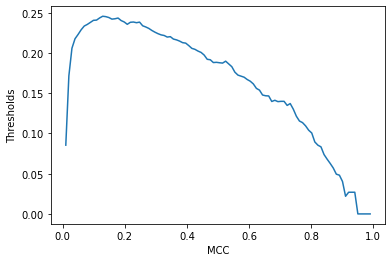

In [200]:
# It's 5.12 am. I'm tired, this code is taken from a Kaggle notebook to plot the MCC
from sklearn.metrics import matthews_corrcoef

thresholds = np.linspace(0.01, 0.99, 100)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
plt.xlabel('MCC')
plt.ylabel('Thresholds')

best_threshold = thresholds[mcc.argmax()]

In [199]:
print("The optimal threshold of the MCC is " + str(round(mcc.max(),3)))

The optimal threshold of the MCC is 0.246


# Feature importance

In [201]:
df_importance = pd.DataFrame({'feature_name':X_trans.columns, 'importance':model_fin.feature_importances_})
df_importance = df_importance.sort_values(by=['importance'], ascending=False)
df_importance_150 = df_importance[:150] 

In [204]:
df_importance_150

,feature_name,importance
149,L3_S32_F3854,0.047177
75,L1_S24_F1723,0.016464
141,L3_S33_F3865,0.013632
140,L3_S33_F3859,0.013241
50,L0_S11_F310,0.012765
...,...,...
142,L3_S33_F3871,0.000000
144,L3_S36_F3918,0.000000
65,L1_S24_F679,0.000000
148,L3_S48_F4193,0.000000


In [208]:
most_important_features = pd.Series(model_fin.feature_importances_, index=X_trans.columns).nlargest(10)
most_important_features.

L3_S32_F3854    0.047177
L1_S24_F1723    0.016464
L3_S33_F3865    0.013632
L3_S33_F3859    0.013241
L0_S11_F310     0.012765
L1_S24_F1846    0.011993
L3_S29_F3357    0.011529
L3_S38_D3953    0.011372
L3_S30_F3494    0.010927
L1_S24_F1695    0.010618
dtype: float32

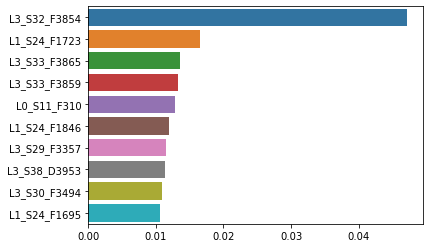

In [211]:
# Plot
sns.barplot(y=most_important_features.index, x=most_important_features.values)
